In [1]:
from fit import fit
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from utils import latexify

In [44]:
vix = yf.download("^VIX", end='2020-10-01')["Adj Close"]
spy = yf.download("SPY", end='2020-10-01')["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [45]:
df = pd.DataFrame({"SPY": spy.pct_change(), "VIX": vix})
df = df[~df.isna().any(axis=1)]
# df = df.iloc[-5500:-1500]
df.index[0], df.index[-1], df.shape

(Timestamp('1993-02-01 00:00:00'), Timestamp('2020-09-30 00:00:00'), (6968, 2))

In [46]:
# df.SPY = np.log(df.SPY.abs().clip(0.0005, 0.03))
df.SPY = df.SPY.abs() * np.sqrt(250)

In [47]:
Xtrain = df.astype(float).values[:df.shape[0]//2, 0]
Xtest = df.astype(float).values[df.shape[0]//2:, 0]
Xmean = Xtrain.mean(axis=0)
Xtrain -= Xmean
Xtest -= Xmean
H = 20
M = 60

In [49]:
z, U, V, Ptrain, Ftrain, info = fit(Xtrain[:, None], M=M, H=H, alpha=.05, kappa=0, niter=20, rank=10, verbose=True)

Setting lam to 0.004.
Setting up forecaster consistency.
0 | 0.14210313139870362
1 | 0.12659540164553568
2 | 0.12651968420989979
3 | 0.1264744201289503
4 | 0.1264468593881009
5 | 0.12642988302755725
6 | 0.12641933782382062
7 | 0.12641275307670927
8 | 0.12640862552596446
9 | 0.12640603029283795
10 | 0.12640439478549886
11 | 0.12640336231321245
12 | 0.126402709667777
13 | 0.12640230473599837
14 | 0.12640203833018634
15 | 0.12640187659608101
16 | 0.12640176740153614
17 | 0.12640170224142888
18 | 0.12640166164803682
19 | 0.12640163581320568
Theta has rank 1
Time: 4.192582130432129


In [50]:
_, _, _, Ptest, Ftest, info = fit(Xtest[:, None], M=M, H=H, alpha=.1, kappa=0, niter=1, rank=10, verbose=True)

Setting lam to 0.018.
Setting up forecaster consistency.
0 | 0.26312853093125166
Theta has rank 1
Time: 0.18384170532226562


In [51]:
np.mean(np.square(Ptest @ U @ V - Ftest))

0.02194567676020577

In [52]:
np.mean(np.square(Ftest))

0.026375112188754973

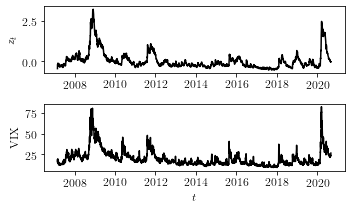

In [53]:
ztest = Ptest @ U
import matplotlib.pyplot as plt
latexify(5)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(df.index[df.shape[0]//2+M:-H+1], -ztest, c='black')
ax1.set_ylabel("$z_t$")
ax2.plot(vix[df.index[df.shape[0]//2+M:-H+1]], c='black')
ax2.set_xlabel("$t$")
ax2.set_ylabel("VIX")
plt.tight_layout()
plt.savefig("figs/spy_latent_state.pdf")

In [54]:
# for alpha in np.linspace(.01, .2, 10):
#     z, U, V, Ptrain, Ftrain, _ = fit(Xtrain[:, None], M=M, H=H, alpha=alpha, kappa=0, niter=20, rank=10, verbose=False)
#     _, _, _, Ptest, Ftest, _ = fit(Xtest[:, None], M=M, H=H, alpha=.8, kappa=0, niter=1, rank=10, verbose=False)
#     print(alpha, np.mean(np.square(Ptest @ U @ V - Ftest)), U.shape[1])

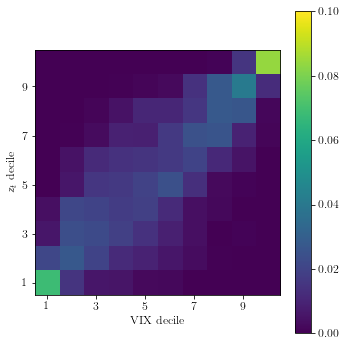

In [64]:
rows = pd.qcut(-ztest.flatten(), np.linspace(0, .9, 10)).codes
cols = pd.qcut(vix[df.index[df.shape[0]//2 + M:-H+1]].values, np.linspace(0, .9, 10)).codes

A = np.zeros((10, 10))
for i, j in zip(rows, cols):
    A[i, j] += 1
latexify(5, 5)
plt.xticks(np.arange(0, 10, 2), np.arange(1, 11, 2))
plt.yticks(np.arange(1, 11, 2), np.arange(1, 11, 2)[::-1])
plt.imshow(A[::-1] / A.sum(), vmin=0, vmax=.1)
plt.colorbar()
plt.ylabel("$z_t$ decile")
plt.xlabel("VIX decile")
plt.tight_layout()
plt.savefig("figs/spy_decile.pdf")

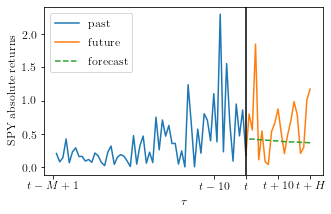

In [56]:
Fhat = Ptest @ U @ V

i = 420
n = 1

latexify(5)
plt.xticks([-60, -10, 0, 10, 20], ["$t-M+1$", "$t-10$", "$t$", "$t+10$", "$t+H$"])
plt.plot(np.arange(-M+1,1), Xmean + Ptest[i].reshape(M, n)[:,0], label='past')
plt.plot(np.arange(0, H+1), Xmean + np.append(Ptest[i].reshape(M, n)[:,0][-1], Ftest[i].reshape(H, n)[:,0]), label='future')
plt.plot(np.arange(1,H+1), Xmean + Fhat[i].reshape(H, n)[:,0], '--', label='forecast')
plt.axvline(0, c='black')
plt.legend()
plt.ylabel("SPY absolute returns")
plt.xlabel("$\\tau$")
plt.savefig("figs/spy_forecast.pdf")

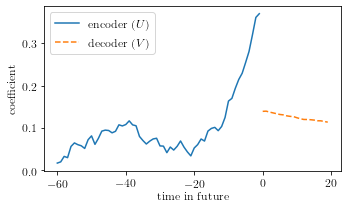

In [57]:
latexify(5)
plt.plot(np.arange(-60, 0), -U, label='encoder ($U$)')
plt.plot(np.arange(20), -V.T, '--', label='decoder ($V$)')
plt.xlabel("time in future")
plt.ylabel("coefficient")
plt.legend()
plt.tight_layout()
plt.savefig("figs/spy_uv.pdf")

In [58]:
np.mean(np.square((Ptest).mean(axis=1)[:, None] - Ftest))

0.024251895720947977

In [59]:
np.mean(np.square(Ftest.mean(axis=1)[:, None] - Ftest))

0.016025929119211125

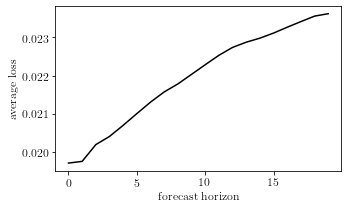

In [60]:
latexify(5)
plt.plot(np.square(Ptest @ U @ V - Ftest).reshape(-1, H, n).mean(axis=(0, 2)), c='black')
plt.xlabel("forecast horizon")
plt.ylabel("average loss")
plt.tight_layout()
plt.savefig("figs/spy_loss_horizon.pdf")